# gamma transform test
During the hackathon, one team's strategy included a log transform of the image to enhance the neurites. It was unclear that this would lead to meaningful changes in pixel based classification since the log transform is a monotonic transformation. Would the *thresholds*, *parameters*, or *boundaries* not appreciably change, because the rank order of the intensity values remains the same; or would altering the weighting of the intensity scale aid the machine learning algorithms in much the same way the gamma transform aids the human eye?

In the end, the log transform did not create a meaningful difference between the original image. However, a similar transform, the gamma transform, did make a difference. A gamma of 0.4 was chosen heuristically as a value that noticebaly enhance the dim neurite sections, and smaller values of gamma failed to created noticeably better enchancement.

In [1]:
%matplotlib inline
import numpy
import os
import os.path
import pandas
import re
import skimage
import skimage.exposure
import skimage.io

In [2]:
image_directory = r"C:\Users\karhohs\Documents\GitHub\workday\ilastik\last_minute"
regex_im = "^(?P<well>[A-Z]\d+)_s(?P<site>\d+)_w(?P<chnum>\d+)\."

In [3]:
def is_my_file(filename, re_obj):
    
    mybool = False
    
    if re_obj.match(filename) is not None:
        
        mybool = True
        
    return mybool

def make_dict(filename, path, re_obj):
    
    my_dict = re_obj.match(filename).groupdict()
    
    my_dict["filename"] = filename
    
    my_dict["path"] = path
    
    return my_dict

In [4]:
re_im = re.compile(regex_im)

im_dict = [make_dict(f, image_directory, re_im) for f in os.listdir(image_directory) if is_my_file(f, re_im)]

im_df = pandas.DataFrame(im_dict)

In [5]:
im_df.chnum = im_df.chnum.astype(numpy.uint16)

im_df.site = im_df.site.astype(numpy.uint16)

im_df_w1 = im_df.loc[im_df["chnum"] == 1]

im_df_w3 = im_df.loc[im_df["chnum"] == 3]

imset_df = pandas.merge(im_df_w1, im_df_w3, on=["well", "site", "path"], suffixes=("_dna", "_neuron"))

imset_df = imset_df.assign(filename_gamma = lambda x: ["{0}_s{1}_gamma.tif".format(i, j) for i, j in zip(x.well, x.site)])

In [6]:
imset_df

,chnum_dna,filename_dna,path,site,well,chnum_neuron,filename_neuron,filename_gamma
0,1,B02_s11_w1.tif,C:\Users\karhohs\Documents\GitHub\workday\ilas...,11,B02,3,B02_s11_w3.tif,B02_s11_gamma.tif
1,1,B02_s12_w1.tif,C:\Users\karhohs\Documents\GitHub\workday\ilas...,12,B02,3,B02_s12_w3.tif,B02_s12_gamma.tif
2,1,B02_s13_w1.tif,C:\Users\karhohs\Documents\GitHub\workday\ilas...,13,B02,3,B02_s13_w3.tif,B02_s13_gamma.tif
3,1,F16_s11_w1.tif,C:\Users\karhohs\Documents\GitHub\workday\ilas...,11,F16,3,F16_s11_w3.tif,F16_s11_gamma.tif


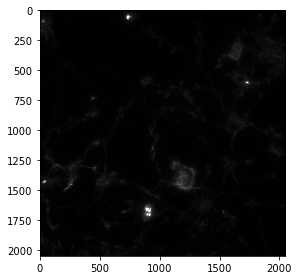

In [7]:
im_neuron1 = skimage.io.imread(os.path.join(imset_df.loc[0]["path"], imset_df.loc[0]["filename_neuron"]))
skimage.io.imshow(im_neuron1)

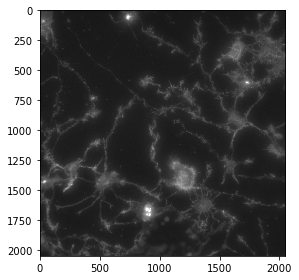

In [8]:
im_neuron_gamma = skimage.exposure.adjust_gamma(im_neuron1,  gamma=0.4)
skimage.io.imshow(im_neuron_gamma)

In [9]:
def df_make_gamma_image(p):
    
    im_neuron = skimage.io.imread(os.path.join(p["path"], p["filename_neuron"]))
    
    im_neuron_gamma = skimage.exposure.adjust_gamma(im_neuron,  gamma=0.4)
    
    im_neuron_gamma = im_neuron_gamma.astype("uint16")
    
    im_dna = skimage.io.imread(os.path.join(p["path"], p["filename_dna"]))
    
    im_stack = numpy.stack((im_dna, im_neuron_gamma))
    
    print(im_stack.shape)
    
    skimage.io.imsave(os.path.join(p["path"], p["filename_gamma"]), im_stack)
    
    return

In [10]:
_ = imset_df.apply(df_make_gamma_image, axis=1)

(2, 2048, 2048)
(2, 2048, 2048)
(2, 2048, 2048)
(2, 2048, 2048)
